# BMI for the bionic arm

As a proof of concept we want to show that our bionic arm can replicate the actions performed by the monkey during a trial.

## Imports

In [1]:
#Adding working directory to python path
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
#Import standard packages
import numpy as np
np.random.seed(27) # Seed is important for having the same test set for performance comparison
import pickle as pkl
import json
from utils.functions import *
from math import ceil
import time

#Import tensorflow
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#Import graphics
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

#Import function to laod and process dataset
from utils.data_processing import * 
from sklearn.preprocessing import LabelEncoder

#Import metrics
from sklearn.metrics import accuracy_score, r2_score, log_loss

#Import decoder functions
from utils.decoders import *

In [3]:
#Turn off deprecation warnings

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Parameters

In [4]:
FILE = 'MRec40'  # MRec40, ZRec50 or ZRec50_Mini
PLOTS_FOLDER = '../plots/online'
PATH = f'../data/Objects Task DL Project/{FILE}.neo.mat' 
EPOCH = 'all'
WINDOW = 10

## Loading Data

In [5]:
try:
    p_window = pkl.load(open(f'../data/online/p_window_{WINDOW}.pkl', 'rb'))
    trial_state = pkl.load(open(f'../data/online/trial_state_{WINDOW}.pkl', 'rb'))
    obj_shape = pkl.load(open(f'../data/online/obj_shape_{WINDOW}.pkl', 'rb'))
    obj_size = pkl.load(open(f'../data/online/obj_size_{WINDOW}.pkl', 'rb'))
    print('Loaded!')
    
except IOError:
    
    def padding_window(my_window, my_states, my_shape, my_size):
        p_window = []
        next_state = []
        shape = []
        size = []
        (n_channels, n_steps) = my_window.shape
        for time_step in range(n_steps-1):
            padded_window = np.zeros((n_channels, n_steps-time_step-1))
            padded_window = np.hstack((padded_window, my_window[:, :time_step+1]))
            p_window.append(padded_window.astype('float32'))
            next_state.append(my_states[time_step+1].strip())
            shape.append(my_shape)
            size.append(my_size)

        return np.array(p_window, dtype='float32'), next_state, shape, size

    def sliding_window(my_window, my_states, my_shape, my_size, w_size=10):
        p_window = []
        next_state = []
        shape = []
        size = []
        (n_channels, n_steps) = my_window.shape
        for time_step in range(n_steps):
            if time_step < w_size-1:
                sliced_window = np.zeros((n_channels, w_size-time_step-1))
                sliced_window = np.hstack((sliced_window, my_window[:, :time_step+1]))
            else:
                sliced_window = my_window[:, time_step-w_size+1:time_step+1]
                
            p_window.append(sliced_window.astype('float32'))
            if time_step == n_steps-1:
                next_state.append('End')
            else:
                next_state.append(my_states[time_step+1].strip())
            shape.append(my_shape)
            size.append(my_size)

        return np.array(p_window, dtype='float32'), next_state, shape, size

    all_measurements, all_objects, all_states = load_dataset(PATH, EPOCH, load_states=True)
    selector = ObjectSelector()
    new_classes = selector.get_non_special(group_labels=True)
    
    # Sort
    n_meas = all_measurements.shape[0]
    rnd = np.random.permutation(n_meas)
    all_measurements = all_measurements[rnd]
    all_objects = all_objects[rnd]
    all_states = all_states[rnd]

    test_dict = {}
    
    p_window = []
    trial_state = []
    obj_shape = []
    obj_size = []

    start_t = time.time()
    for i in progressbar(range(n_meas), "Preparing dataset: ", 80):
        # check if object[i] belong to useful classes
        obj = all_objects[i]
        for (elements, label) in new_classes:
            if str(obj) in elements:
                # check if one trial is already stored separately
                if label not in test_dict.keys():
                    test_dict[label] = {
                        'trial': all_measurements[i],
                        'states': all_states[i],
                        'obj_shape': label,
                        'obj_size': str(obj)[1]
                    }
                    break
                #a, b, c, d = padding_window(all_measurements[i], all_states[i], label, str(obj)[1])
                a, b, c, d = sliding_window(all_measurements[i], all_states[i], label, str(obj)[1], w_size=WINDOW)
                p_window.append(a.astype('int32'))
                trial_state.append(b)
                obj_shape.append(c)
                obj_size.append(d)
                break
    print(f'{round(time.time()-start_t, 3)}s')
    
    print('\n###\n    Reshaping..', end='  ')
    start_t = time.time()
    p_window = np.vstack(p_window).astype('int32')
    trial_state = np.hstack(trial_state)
    obj_shape = np.hstack(obj_shape)
    obj_size = np.hstack(obj_size)
    print(f'[{round(time.time()-start_t, 3)}s]')
    
    print('    Shuffling..', end='  ')
    start_t = time.time()
    rnd = np.random.permutation(len(p_window))
    p_window = p_window[rnd]
    trial_state = trial_state[rnd]
    obj_shape = obj_shape[rnd]
    obj_size = obj_size[rnd]
    print(f'[{round(time.time()-start_t, 3)}s]')

    print('    Saving..', end='     ')
    start_t = time.time()
    pkl.dump(test_dict, open(f'../data/online/test_dict_{WINDOW}.pkl', "wb"))
    pkl.dump(p_window, open(f'../data/online/p_window_{WINDOW}.pkl', "wb"))
    pkl.dump(trial_state, open(f'../data/online/trial_state_{WINDOW}.pkl', "wb"))
    pkl.dump(obj_shape, open(f'../data/online/obj_shape_{WINDOW}.pkl', "wb"))
    pkl.dump(obj_size, open(f'../data/online/obj_size_{WINDOW}.pkl', "wb"))
    print(f'[{round(time.time()-start_t, 3)}s]\n###')
    print('\nFinished!')

Loaded!


In [6]:
print(p_window.shape, trial_state.shape, obj_shape.shape, obj_size.shape)

(55878, 552, 10) (55878,) (55878,) (55878,)


## Plotting functions

In [11]:
def display_dataset_distribution(unique_class, n_repetition, class_name='classes', save=True):
    fig, ax = plt.subplots(figsize = (18 - (36-len(unique_class))*8/31, 5))
    rects = ax.bar(list(range(len(unique_class))), n_repetition, alpha=0.7)
    ax.set_xticks(list(range(len(unique_class))))
    ax.set_xticklabels(unique_class)

    ax.set_ylim([0, max(n_repetition)*1.15])
    ax.axhline(y=n_repetition.mean(), color='midnightblue', linestyle='-', label='mean', lw=1)
    ax.axhspan(n_repetition.mean()-n_repetition.std(), n_repetition.mean()+n_repetition.std(), alpha=0.4, color='orange', label='std')
    ax.set_xlabel('class', fontsize=12)
    ax.set_ylabel('repetitions', fontsize=12)
    ax.set_title(f'Distribution of {class_name} examples in the dataset', fontsize=14)
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
    plt.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.96], pad=3.0)
    if save:
        fig.savefig(f'{PLOTS_FOLDER}/{class_name.replace(" ", "_")}_distribution.png')
    plt.show()

In [12]:
def display_training_phase(history, network_name='Network', save=True):    
    fig = plt.figure(figsize=(16, 6))
    fig.suptitle(f'{network_name} training phase', fontsize=16)
    gs = gridspec.GridSpec(nrows=1, ncols=2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title('Loss trend in training phase', fontsize=14)
    ax1.plot(history.history['loss'], label='training set')
    ax1.plot(history.history['val_loss'], label='validation set')
    ax1.legend()
    ax1.set_xlabel('epoch', fontsize=12)
    ax1.set_ylabel('cross entropy loss', fontsize=12)

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title('Accuracy trend in training phase', fontsize=14)
    ax2.plot(history.history['accuracy'], label='training set')
    ax2.plot(history.history['val_accuracy'], label='validation set')
    ax2.legend()
    ax2.set_xlabel('epoch', fontsize=12)
    ax2.set_ylabel('accuracy', fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96], pad=3.0)
    if save:
        fig.savefig(f'{PLOTS_FOLDER}/{network_name.replace(" ", "_")}_training_history.png')
    plt.show()

In [13]:
def display_testing_phase_results(conf_matrix, my_labels, errors_distribution, network_name='network', save=True):
    fig = plt.figure(figsize=(14, 9))
    fig.suptitle(f'Performances of {network_name} testing', fontsize=16)
    gs = gridspec.GridSpec(nrows=3, ncols=3)

    ax1 = fig.add_subplot(gs[:, :-1])
    ax1.set_title('Confusion matrix', fontsize=14)
    conf_matrix_norm = normalize(conf_matrix, axis=1, norm='l1')
    im = ax1.imshow(conf_matrix_norm, cmap=sns.cubehelix_palette(as_cmap=True, light=.95, gamma=0.75), vmin=0, vmax=1)

    ax1.vlines([i + 0.5 for i in range(n_outputs)], -0.5, n_outputs - 0.5, linewidth=2, colors='White')
    ax1.hlines([i + 0.5 for i in range(n_outputs)], -0.5, n_outputs - 0.5, linewidth=2, colors='White')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    rows, columns = conf_matrix.shape
    for i in range(rows):
        for j in range(columns):
            c = conf_matrix[i][j]
            if c > 0:
                color = 'White' if conf_matrix_norm[i][j]>=.65 else 'Black'
                ax1.text(j, i, str(round(c,0)), va='center', ha='center', c=color, fontsize=12)
    ax1.set_xticks(list(range(n_outputs)))
    ax1.set_yticks(list(range(n_outputs)))
    ax1.set_xticklabels(my_labels)
    ax1.set_yticklabels(my_labels)
    ax1.set_ylabel('true value', fontsize=12)
    ax1.set_xlabel('prediction', fontsize=12)

    ax2 = fig.add_subplot(gs[0, -1])
    ax2.set_title('Distance from the diagonal', fontsize=14)
    x = list(errors_distribution.keys())
    x.sort()
    y = [errors_distribution[distance] for distance in x]
    ax2.step(x, y, where='mid', c='midnightblue')
    ax2.axvspan(-1.5, 1.5, alpha=0.4, color='palevioletred')
    x_max = min(max(list(errors_distribution.keys())), 10)
    lim = x_max if x_max%2 == 0 else x_max-1
    lim = min(lim, 10)
    ax2.set_xticks(list(range(-lim, lim+2, 2)))
    ax2.set_xlim(-x_max, x_max)
    ax2.set_yscale('log')
    ax2.set_ylabel('n errors', fontsize=12)
    ax2.set_xlabel('distance', fontsize=12, y=-10)
    
    e0 = errors_distribution[0]
    e1 = errors_distribution[1]+errors_distribution[-1]
    
    ax3 = fig.add_subplot(gs[1, -1])
    ax3.axis('off')
    ax3.text(0,0.9,f'Distance 0: {round(e0, 3)} [{round(e0/len(y_test)*100, 1)}%]', fontsize=11.5)
    ax3.text(0,0.8,f'Distance ±1: {round(e0+e1, 3)} [{round((e0+e1)/len(y_test)*100, 1)}%]', fontsize=11.5)


    plt.tight_layout(rect=[0, 0, 1, 0.96], pad=3.0)
    if save:
        fig.savefig(f'{PLOTS_FOLDER}/{network_name.replace(" ", "_")}_testing_results.png')
    plt.show()

# PART 1: recognise shape
The first task is that of recognizing only the shape of the object; I will proceed checking whether the dataset is balanced and then training the network

#### Dataset analysis

X:padded windows; Y:object shape
(21178, 552, 10) (21178,)

Object shape repetitions in the dataset:
('balls', 3820)   ('boxes', 3923)   ('cubes', 2964)   ('hCylinder', 3707)   ('rings', 3499)   ('vCylinder', 3265)   

Dataset internal variation [332.019] is 9.0% of the average classes representation [3530.0]: 
	Not balanced!


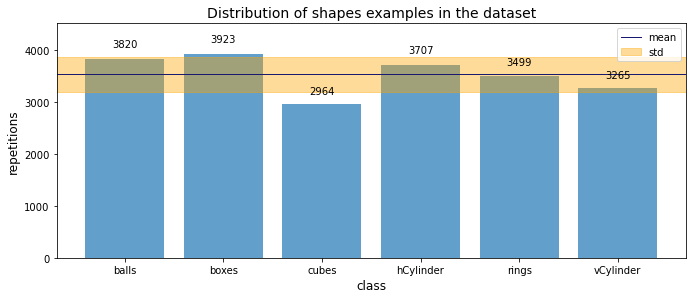

In [36]:
to_keep = np.isin(trial_state, ['Cue', 'Mem', 'React', 'Go'])
X = p_window[to_keep]  #[:int(len(p_window)/2)]
Y = obj_shape[to_keep]  #[:int(len(p_window)/2)]
print('X:padded windows; Y:object shape')
print(X.shape, Y.shape)

unique_shapes, n_repetition = np.unique(Y, return_counts=True, axis=0)
print('\nObject shape repetitions in the dataset:' )
for elem in zip(unique_shapes, n_repetition):
    print(elem, end='   ')

balance = n_repetition.std()/n_repetition.mean()*100
print(f'\n\nDataset internal variation [{round(n_repetition.std(), 3)}] is {round(balance, 0)}% of the average classes representation [{round(n_repetition.mean(), 0)}]: \n\t{"Balanced!" if balance < 5 else "Not balanced!"}')

display_dataset_distribution(unique_shapes, n_repetition, 'shapes')

#### Data preprocessing

In [38]:
np.save('../results/online/windows_shape_min_max.npy', np.array([X.min(), X.max()]))
X = (X.astype('float32') - X.min()) / (X.max() - X.min())
(_, n_channels, n_steps) = X.shape

shape_encoder = LabelEncoder()
Y = tf.keras.utils.to_categorical(shape_encoder.fit_transform(Y))
np.save('../results/online/shape_encoding.npy', shape_encoder.classes_)

(_, n_outputs) = Y.shape

# Splitting Sets
tr_idx = round(len(Y) * 0.7)
val_idx = round(len(Y) * (0.7 + 0.15))
x_train = X[:tr_idx]
y_train = Y[:tr_idx]
x_val = X[tr_idx:val_idx]
y_val = Y[tr_idx:val_idx]
x_test = X[val_idx:]
y_test = Y[val_idx:]

print(f'train: {x_train.shape} -- validation: {x_val.shape} -- test: {x_test.shape}')

train: (14825, 552, 10) -- validation: (3176, 552, 10) -- test: (3177, 552, 10)


#### Training phase

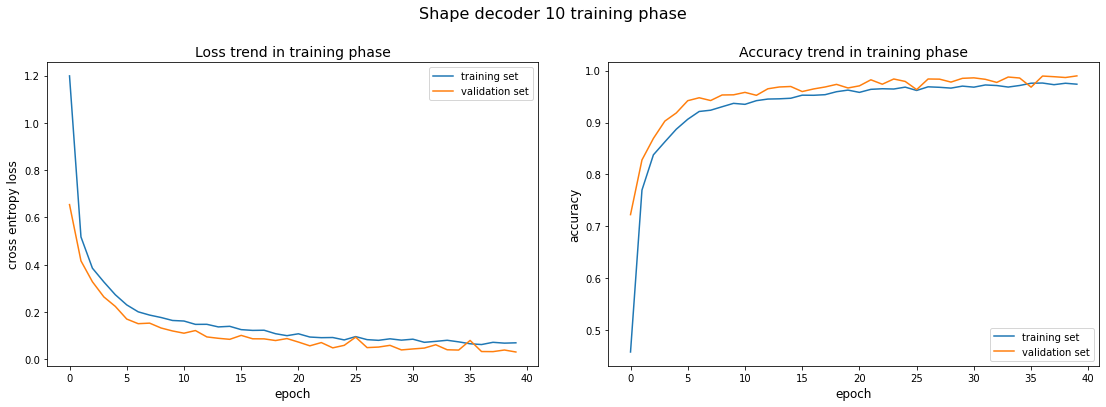

In [63]:
# Loading hyperparameters
with open('../utils/hyperparameters.json', 'r') as f:
    config_dict = json.load(f)
params = config_dict['eegnet2']

# Building network
network = EEGNetv2(n_channels, n_outputs,
                      filters=[params['n_filters_1']],
                      filters_size=[int(params['size_1'])],
                      dropout=params['frac_dropout'],
                      units=int(params['n_units']),
                      neurons=params['n_neurons'])

# Training
history = network.fit(x_train, y_train, x_val, y_val, num_epochs=1000, batch_size=100, verbose=0)
network.model.save(f'../results/online/shape_decoder_{WINDOW}.h5')

# Displaying
display_training_phase(history, f'Shape decoder {WINDOW}')

#### Testing phase

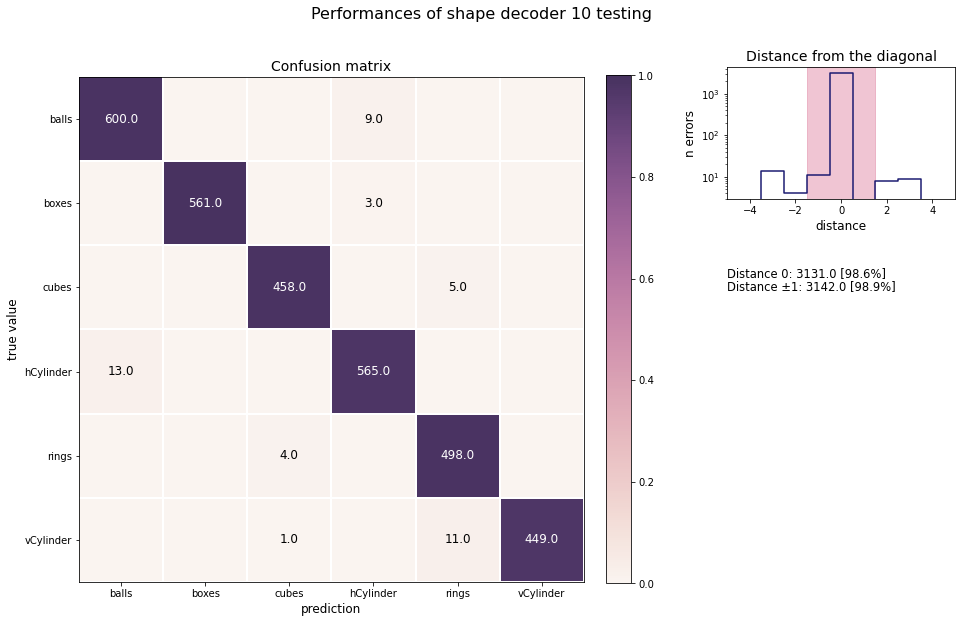

In [49]:
# Loading trained model
network = tf.keras.models.load_model(f'../results/online/shape_decoder_{WINDOW}.h5')

# Predicting
prediction = network.predict(x_test)

# Metrics
conf_matrix, my_labels = my_confusion_matrix(shape_encoder.inverse_transform(prediction.argmax(axis=1)), shape_encoder.inverse_transform(y_test.argmax(axis=1)), labels=shape_encoder.classes_, return_labels=True)
errors_distribution = distance_from_diagonal(conf_matrix)

# Displaying
display_testing_phase_results(conf_matrix, my_labels, errors_distribution, f'shape decoder {WINDOW}')

# PART2: recognise size
The second task is that of recognizing only the size of the object; I will proceed checking whether the dataset is balanced and then training the network

#### Dataset analysis

X:padded windows; Y:object size
(21178, 552, 10) (21178,)

Object size repetitions in the dataset:
('1', 3638)   ('2', 3472)   ('3', 3544)   ('4', 3656)   ('5', 3489)   ('6', 3379)   

Dataset internal variation [96.247] is 3.0% of the average classes representation [3530.0]: 
	Balanced!


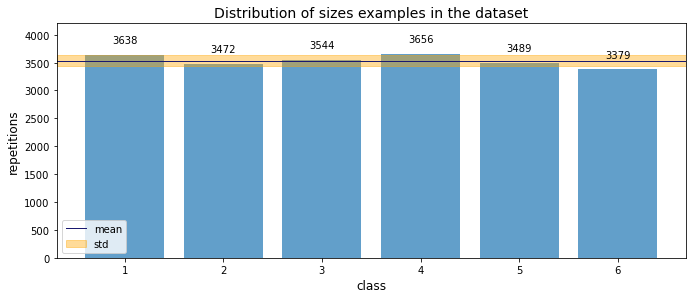

In [40]:
to_keep = np.isin(trial_state, ['Cue', 'Mem', 'React', 'Go'])
X = p_window[to_keep]  #[:int(len(p_window)/2)]
Y = obj_size[to_keep]  #[:int(len(p_window)/2)]
print('X:padded windows; Y:object size')
print(X.shape, Y.shape)

unique_sizes, n_repetition = np.unique(Y, return_counts=True, axis=0)
print('\nObject size repetitions in the dataset:' )
for elem in zip(unique_sizes, n_repetition):
    print(elem, end='   ')
    
balance = n_repetition.std()/n_repetition.mean()*100
print(f'\n\nDataset internal variation [{round(n_repetition.std(), 3)}] is {round(balance, 0)}% of the average classes representation [{round(n_repetition.mean(), 0)}]: \n\t{"Balanced!" if balance < 5 else "Not balanced!"}')

display_dataset_distribution(unique_sizes, n_repetition, 'sizes')

#### Data preprocessing
Windows must be normalized and target value one-hot encoded

In [42]:
np.save('../results/online/windows_size_min_max.npy', np.array([X.min(), X.max()]))
X = (X.astype('float32') - X.min()) / (X.max() - X.min())
(_, n_channels, n_steps) = X.shape

size_encoder = LabelEncoder()
Y = tf.keras.utils.to_categorical(size_encoder.fit_transform(Y))
np.save('../results/online/size_encoding.npy', size_encoder.classes_)
(_, n_outputs) = Y.shape

tr_idx = round(len(Y) * 0.7)
val_idx = round(len(Y) * (0.7 + 0.15))
x_train = X[:tr_idx]
y_train = Y[:tr_idx]
x_val = X[tr_idx:val_idx]
y_val = Y[tr_idx:val_idx]
x_test = X[val_idx:]
y_test = Y[val_idx:]

print(f'train: {x_train.shape} -- validation: {x_val.shape} -- test: {x_test.shape}')

train: (14825, 552, 10) -- validation: (3176, 552, 10) -- test: (3177, 552, 10)


#### Training phase

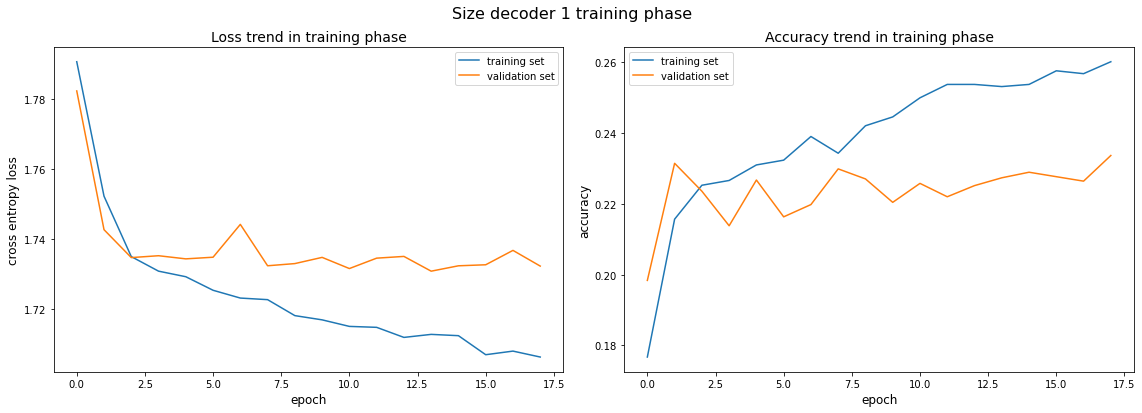

In [15]:
# Loading hyperparameters
with open('../utils/hyperparameters.json', 'r') as f:
    config_dict = json.load(f)
params = config_dict['eegnet2']

# Building network
network = EEGNetv2(n_channels, n_outputs,
                      filters=[params['n_filters_1']],
                      filters_size=[int(params['size_1'])],
                      dropout=params['frac_dropout'],
                      units=int(params['n_units']),
                      neurons=params['n_neurons'])

# Training
history = network.fit(x_train, y_train, x_val, y_val, num_epochs=1000, batch_size=100, verbose=0)
network.model.save(f'../results/online/size_decoder_{WINDOW}.h5')

# Displaying
display_training_phase(history, f'Size decoder {WINDOW}')

#### Testing phase

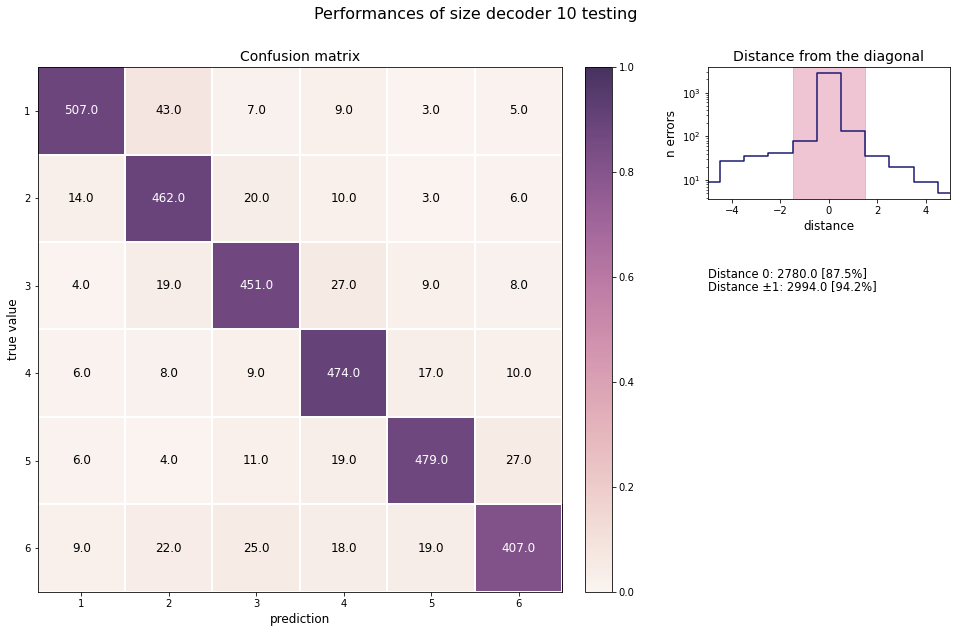

In [55]:
# Loading trained model
network = tf.keras.models.load_model(f'../results/online/size_decoder_{WINDOW}.h5')

# Predicting
prediction = network.predict(x_test)

# Metrics
conf_matrix, my_labels = my_confusion_matrix(size_encoder.inverse_transform(prediction.argmax(axis=1)), size_encoder.inverse_transform(y_test.argmax(axis=1)), labels=size_encoder.classes_, return_labels=True)
errors_distribution = distance_from_diagonal(conf_matrix)

# Displaying
display_testing_phase_results(conf_matrix, my_labels, errors_distribution, f'size decoder {WINDOW}')

# PART3: recognise epoch
The last task is that of predicting the next trial phase; I will proceed checking whether the dataset is balanced and then training the network

#### Dataset analysis

X:padded windows; Y:trial state
(55878, 552, 10) (55878,)
['Start', 'Rest']  not present after sliding window processing

Trial states repetitions in the dataset:
('Motor', 12955) ('FixLOn', 2343) ('Fix', 6421) ('Cue', 6890) ('Mem', 7878) ('React', 448) ('Go', 5962) ('Hold', 4918) ('Rew', 576) ('Intert', 6683) ('End', 804) 

Dataset internal variation [3640.796] is 72.0% of the average classes representation [5080.0]: 
	Not balanced!


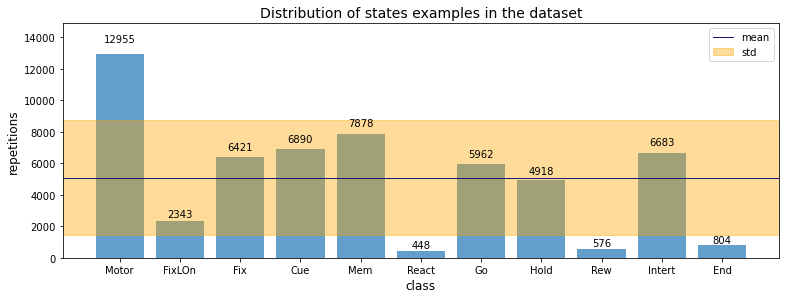

In [21]:
X = p_window
Y = trial_state
print('X:padded windows; Y:trial state')
print(X.shape, Y.shape)

unique_states, n_repetition = np.unique(Y, return_counts=True, axis=0)

# Reordering the labels to match the chronological order of phases instead of the alphabetical one
states_order = []
ordered_states = ['Start', 'Rest', 'Motor', 'FixLOn', 'Fix', 'Cue', 'Mem', 'React', 'Go', 'Hold', 'Rew', 'Intert', 'End']
missing = []
for ep in ordered_states:
    try:
        states_order.append(list(unique_states).index(ep))
    except ValueError:
        missing.append(ep)
print(missing, ' not present after sliding window processing')
        
print('\nTrial states repetitions in the dataset:' )
for elem in zip(unique_states[states_order], n_repetition[states_order]):
    print(elem, end=' ')

balance = n_repetition.std()/n_repetition.mean()*100
print(f'\n\nDataset internal variation [{round(n_repetition.std(), 3)}] is {round(balance, 0)}% of the average classes representation [{round(n_repetition.mean(), 0)}]: \n\t{"Balanced!" if balance < 5 else "Not balanced!"}')

display_dataset_distribution(unique_states[states_order], n_repetition[states_order], 'states')

#### Addressing unbalancement


Trial states repetitions after grouping:
('Waiting', 21719) ('Cue', 6890) ('Planning', 7878) ('Movement', 6410) ('Hold', 5494) ('End', 7487) 

Dataset internal variation [5600.378] is 60.0% of the average classes representation [9313.0]: 
	Not balanced!


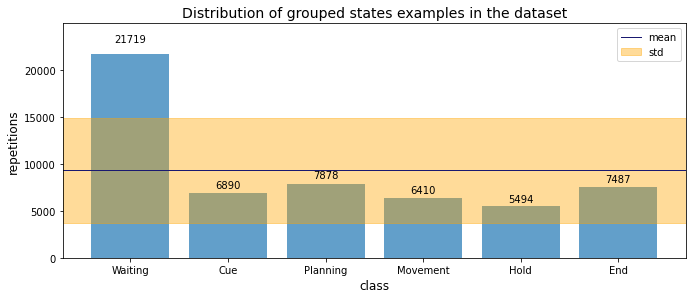

In [26]:
fixation = 0
cue = 0
planning = 0
movement = 0
hold = 0
end = 0

for elem in zip(unique_states[states_order], n_repetition[states_order]):
    if elem[0] in ['Start', 'Rest', 'Motor', 'FixLOn', 'Fix']:
        fixation += elem[1]
    elif elem[0] in ['Cue']:
        cue += elem[1]
    elif elem[0] in ['Mem']:
        planning += elem[1]
    elif elem[0] in ['React', 'Go']:
        movement += elem[1]
    elif elem[0] in ['Hold', 'Rew']:
        hold += elem[1]
    elif elem[0] in ['Intert', 'End']:
        end += elem[1]

new_states = ['Waiting', 'Cue', 'Planning', 'Movement', 'Hold', 'End']
new_repetitions = np.array([fixation, cue, planning, movement, hold, end])

#my_cap = find_cap_to_balance(new_repetitions, 10)
#new_repetitions = np.array([rep if rep <= my_cap else my_cap for rep in new_repetitions])

print('\nTrial states repetitions after grouping:' )
for elem in zip(new_states, new_repetitions):
    print(elem, end=' ')

balance = new_repetitions.std()/new_repetitions.mean()*100
print(f'\n\nDataset internal variation [{round(new_repetitions.std(), 3)}] is {round(balance, 0)}% of the average classes representation [{round(new_repetitions.mean(), 0)}]: \n\t{"Balanced!" if balance < 10 else "Not balanced!"}')

display_dataset_distribution(new_states, new_repetitions, 'grouped states')

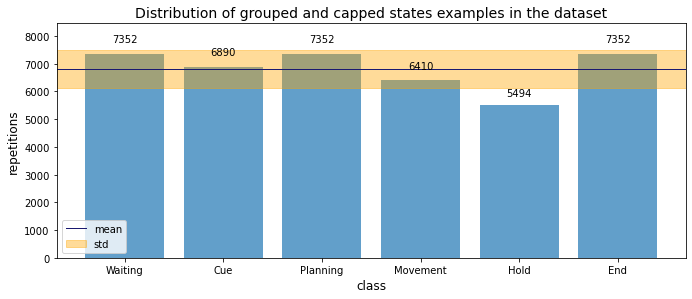

In [28]:
# Evaluating the minimum cap to guarantee a balance margin of 10%
my_cap = find_cap_to_balance(new_repetitions, 10)
new_repetitions = np.array([rep if rep <= my_cap else my_cap for rep in new_repetitions])
display_dataset_distribution(new_states, new_repetitions, 'grouped and capped states')

# Relabeling all the y in the dataset and keep only {cap} of each one
# 'Waiting', 'Cue', 'Planning', 'Movement', 'Hold', 'End'
phase_dict = {
    'Waiting': np.where(np.isin(trial_state, ['Start', 'Rest', 'Motor', 'FixLOn', 'Fix']))[0],
    'Cue': np.where(np.isin(trial_state, ['Cue']))[0],
    'Planning': np.where(np.isin(trial_state, ['Mem']))[0],
    'Movement': np.where(np.isin(trial_state, ['React', 'Go']))[0],
    'Hold': np.where(np.isin(trial_state, ['Hold', 'Rew']))[0],
    'End': np.where(np.isin(trial_state, ['Intert', 'End']))[0]
}

X_balanced = []
Y_balanced = []

for phase, new_rep in zip(new_states, new_repetitions): #important to read them in chronological order
    phase_idx = phase_dict[phase]
    to_keep = min(my_cap, new_rep)
    X_balanced.append(p_window[phase_idx][:to_keep])
    Y_balanced.append([phase]*to_keep)
    
X_balanced = np.vstack(X_balanced).astype('int32')
Y_balanced = np.hstack(Y_balanced)

rnd = np.random.permutation(len(Y_balanced))
X = X_balanced[rnd]
Y = Y_balanced[rnd]


#### Data preprocessing
Windows must be normalized and target value one-hot encoded

In [32]:
np.save('../results/online/windows_state_min_max.npy', np.array([X.min(), X.max()]))
X = (X.astype('float32') - X.min()) / (X.max() - X.min())
(_, n_channels, n_steps) = X.shape

state_encoder = LabelEncoder()
Y = tf.keras.utils.to_categorical(state_encoder.fit_transform(Y))
np.save('../results/online/state_encoding.npy', state_encoder.classes_)
(_, n_outputs) = Y.shape

tr_idx = round(len(Y) * 0.7)
val_idx = round(len(Y) * (0.7 + 0.15))
x_train = X[:tr_idx]
y_train = Y[:tr_idx]
x_val = X[tr_idx:val_idx]
y_val = Y[tr_idx:val_idx]
x_test = X[val_idx:]
y_test = Y[val_idx:]

print(f'train: {x_train.shape} -- validation: {x_val.shape} -- test: {x_test.shape}')

train: (28595, 552, 10) -- validation: (6127, 552, 10) -- test: (6128, 552, 10)


#### Training phase

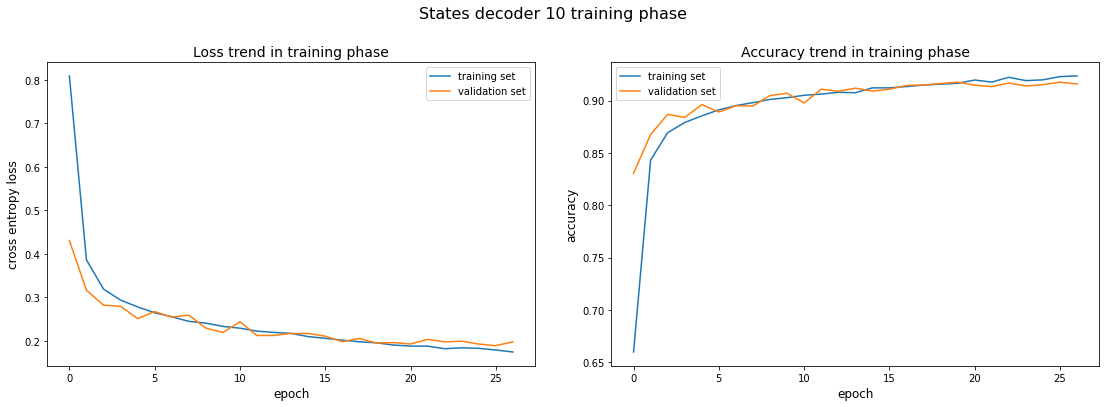

In [39]:
# Loading hyperparameters
with open('../utils/hyperparameters.json', 'r') as f:
    config_dict = json.load(f)
params = config_dict['eegnet2']

# Building network
network = EEGNetv2(n_channels, n_outputs,
                      filters=[params['n_filters_1']],
                      filters_size=[int(params['size_1'])],
                      dropout=params['frac_dropout'],
                      units=int(params['n_units']),
                      neurons=params['n_neurons'])

# Training
history = network.fit(x_train, y_train, x_val, y_val, num_epochs=1000, batch_size=100, verbose=0)
network.model.save(f'../results/online/state_decoder_{WINDOW}.h5')

# Displaying
display_training_phase(history, f'States decoder {WINDOW}')

## Testing phase

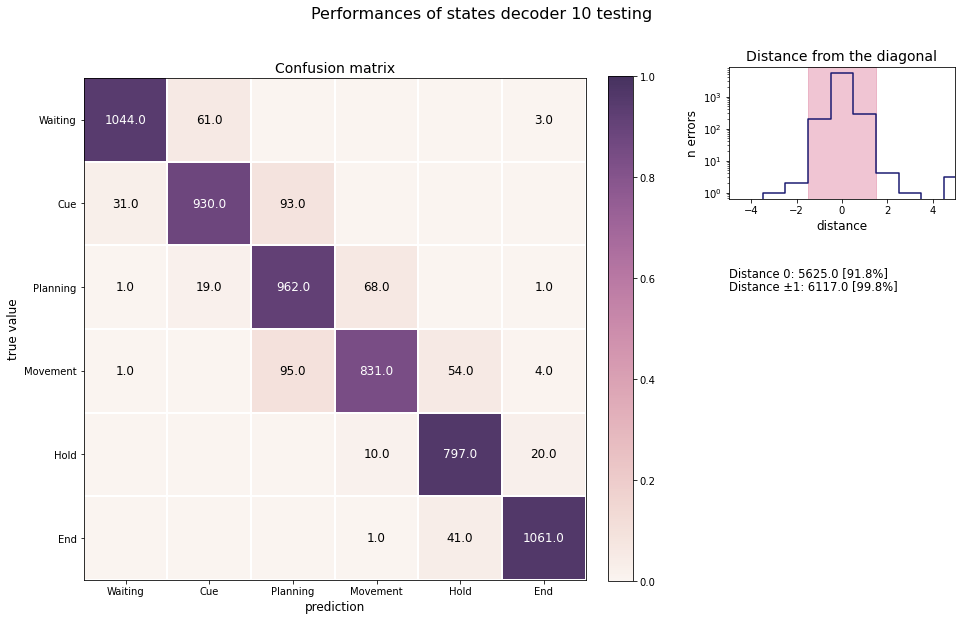

In [65]:
# Loading trained model
network = tf.keras.models.load_model(f'../results/online/state_decoder_{WINDOW}.h5')

# Predicting
prediction = network.predict(x_test)

# Metrics
conf_matrix, my_labels = my_confusion_matrix(state_encoder.inverse_transform(prediction.argmax(axis=1)), state_encoder.inverse_transform(y_test.argmax(axis=1)), labels=new_states, return_labels=True)
errors_distribution = distance_from_diagonal(conf_matrix)

# Displaying
display_testing_phase_results(conf_matrix, my_labels, errors_distribution, f'states decoder {WINDOW}')